In [ ]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-1d71bac5-a341-449f-9ca7-b29de95e771a',
    'iam_service_endpoint': 'https://iam.eu-gb.bluemix.net/oidc/token',
    'api_key': 'ejujKveBRS3Bk7l3pzjemEQDhTSaOKmqCg6x6osXWkx4'
}

configuration_name = 'os_2d970470a6354234a1716fe9f4db519b_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

df = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('US_Accidents_Dec19.csv', 'bdppproject-donotdelete-pr-nejualq57kuqe4'))

In [49]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
try:
    conf = SparkConf().setAppName('Spark Project')
    sc = SparkContext(conf=conf)
except Exception as e:
    print(e)
    
spark = SparkSession \
    .builder \
    .appName("Spark Project") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df = spark.read.load("data/US_Accidents_Dec19.csv",format="csv", sep=",", inferSchema="true", header="true")

Cannot run multiple SparkContexts at once; existing SparkContext(app=Spark Project, master=local[*]) created by __init__ at <ipython-input-1-618796f0693f>:5 


In [45]:
sc

<SparkContext master=local[*] appName=Spark Project>

# Imports

In [3]:
from pyspark.sql.functions import when, count, col, isnan, countDistinct,from_unixtime,from_utc_timestamp, unix_timestamp,split, to_timestamp, hour, month
import seaborn as sns 
import matplotlib.pyplot as plt 

# Due to problem in spark 3.0.0
spark.conf.set("spark.sql.legacy.utcTimestampFunc.enabled", "true")

# Define variables

In [4]:
# Define data information

# Label
colLabel = ["Severity"]
# Categorical values
colCat = ['TMC',
        'Street',
        'Side',
        'City',
        'County',
        'State',
        'Zipcode',
        'Country',
        'Airport_Code',
        'Wind_Direction',
        'Weather_Condition',
        'Amenity',
        'Bump',
        'Crossing',
        'Give_Way',
        'Junction',
        'No_Exit',
        'Railway',
        'Roundabout',
        'Station',
        'Stop',
        'Traffic_Calming',
        'Traffic_Signal',
        'Turning_Loop',
        'Sunrise_Sunset',
        'Civil_Twilight',
        'Nautical_Twilight',
        'Astronomical_Twilight',
]

# Removable columns (Since we dont have the tools for it at the moment, example: Text analysis)
colRem = ['ID', 'Source','End_Time', 'End_Lat', 'End_Lng', 'Description','Timezone']

# Numerical values
colNum = list(filter(lambda x: x not in colLabel and x not in colCat and x not in colRem , df.columns))

# 1. Analysis

In [5]:
print(f"Categories:\n \
Labels: {len(colLabel)}\n \
Classes: {len(colCat)}\n \
Removed: {len(colRem)}\n \
Numerical: {len(colNum)}") 

print(f"Rows: {df.count()}\nColumns {len(df.columns)}")
df.printSchema()
df.take(1)

Categories:
 Labels: 1
 Classes: 28
 Removed: 7
 Numerical: 13
Rows: 2974335
Columns 49
root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- TMC: double (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Number: double (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: string (nullable = tr

[Row(ID='A-1', Source='MapQuest', TMC=201.0, Severity=3, Start_Time='2016-02-08 05:46:00', End_Time='2016-02-08 11:00:00', Start_Lat=39.865147, Start_Lng=-84.058723, End_Lat=None, End_Lng=None, Distance(mi)=0.01, Description='Right lane blocked due to accident on I-70 Eastbound at Exit 41 OH-235 State Route 4.', Number=None, Street='I-70 E', Side='R', City='Dayton', County='Montgomery', State='OH', Zipcode='45424', Country='US', Timezone='US/Eastern', Airport_Code='KFFO', Weather_Timestamp='2016-02-08 05:58:00', Temperature(F)=36.9, Wind_Chill(F)=None, Humidity(%)=91.0, Pressure(in)=29.68, Visibility(mi)=10.0, Wind_Direction='Calm', Wind_Speed(mph)=None, Precipitation(in)=0.02, Weather_Condition='Light Rain', Amenity=False, Bump=False, Crossing=False, Give_Way=False, Junction=False, No_Exit=False, Railway=False, Roundabout=False, Station=False, Stop=False, Traffic_Calming=False, Traffic_Signal=False, Turning_Loop=False, Sunrise_Sunset='Night', Civil_Twilight='Night', Nautical_Twilight=

## Get missing data

In [6]:
# Check data

df_missingVals_colNum = df.select([count(when(col(c).isNull(), c)).alias(c) for c in colNum])
df_missingVals_colCat = df.select([count(when(col(c).isNull(), c)).alias(c) for c in colCat])

# Missing value in each column
df_missingVals_colCat.collect()
df_missingVals_colNum.collect()

[Row(Start_Time=0, Start_Lat=0, Start_Lng=0, Distance(mi)=0, Number=1917605, Weather_Timestamp=36705, Temperature(F)=56063, Wind_Chill(F)=1852623, Humidity(%)=59173, Pressure(in)=48142, Visibility(mi)=65691, Wind_Speed(mph)=440840, Precipitation(in)=1998358)]

In [7]:
#df_missingVals_colNum.groupBy()

#rdd = sc.parallelize(df_missingVals_colNum.collect())
#rdd.first()
#rdd.filter(lambda x: x > 10000).first()
#rdd.filter(lambda c: int(c) > 10000).collect()
# TODO: NOT WORKING



In [8]:
# How many that is above 30%
#missingLimit = df.count() - df.count()*0.3 

#df.select([when(count(when(col(c).isNull(), c)) > missingLimit, c).alias(c) for c in df.columns]).collect()[0].asDict()
#df.filter(lambda c: print(type(c)))
#df.where([when(count(when(col(c).isNull(), c)) > missingLimit, c).alias(c) for c in df.columns] != None).show()

#df.agg(*[
#    when(count(c) < missingLimit,c).alias(c)    # vertical (column-wise) operations in SQL ignore NULLs
#    for c in df.columns
#]).show()

## Get categorical values

In [9]:
# Checking how many classes that can be used
df.agg(*(countDistinct(col(c)).alias(c) for c in colCat)).collect()[0].asDict()

{'TMC': 21,
 'Street': 160715,
 'Side': 3,
 'City': 11685,
 'County': 1713,
 'State': 49,
 'Zipcode': 377152,
 'Country': 1,
 'Airport_Code': 1995,
 'Wind_Direction': 24,
 'Weather_Condition': 120,
 'Amenity': 2,
 'Bump': 2,
 'Crossing': 2,
 'Give_Way': 2,
 'Junction': 2,
 'No_Exit': 2,
 'Railway': 2,
 'Roundabout': 2,
 'Station': 2,
 'Stop': 2,
 'Traffic_Calming': 2,
 'Traffic_Signal': 2,
 'Turning_Loop': 1,
 'Sunrise_Sunset': 2,
 'Civil_Twilight': 2,
 'Nautical_Twilight': 2,
 'Astronomical_Twilight': 2}

## Severity

In [59]:
severity_freq = df.groupBy('Severity').count().orderBy('count',ascending=False).collect()

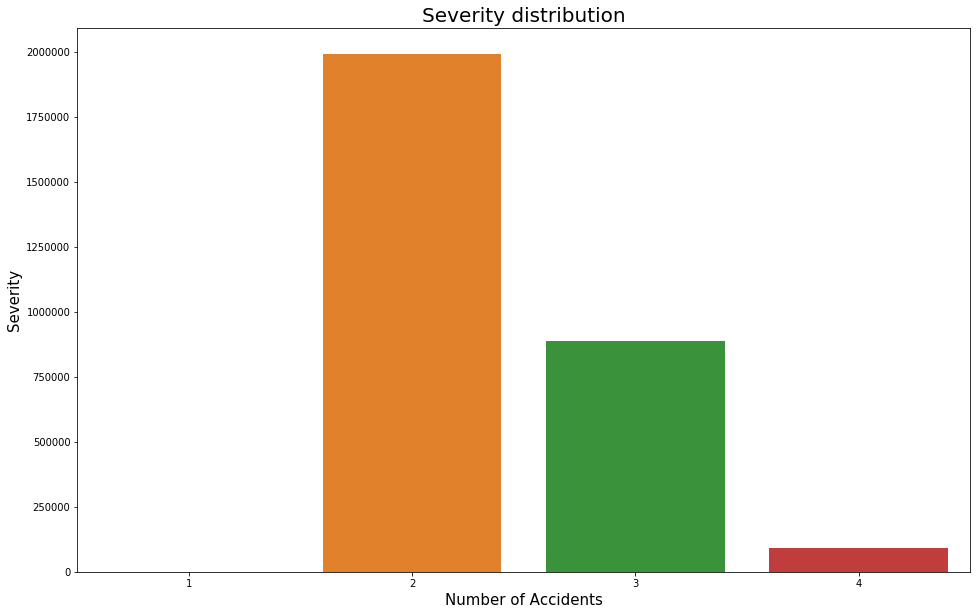

In [60]:
rdd = sc.parallelize(severity_freq)
pd_severity = rdd.toDF().toPandas()

# Plot data
fig,ax = plt.subplots(figsize=(16,10))
b = sns.barplot(pd_severity['Severity'],pd_severity['count'])
b.axes.set_title("Severity distribution",fontsize=20)
b.set_xlabel("Number of Accidents",fontsize=15)
b.set_ylabel("Severity",fontsize=15)
b.tick_params(labelsize=10)

## Causes

### Frequency of severity and state

In [10]:
state_freq = df.groupBy('State').count().orderBy('count',ascending=False).collect()

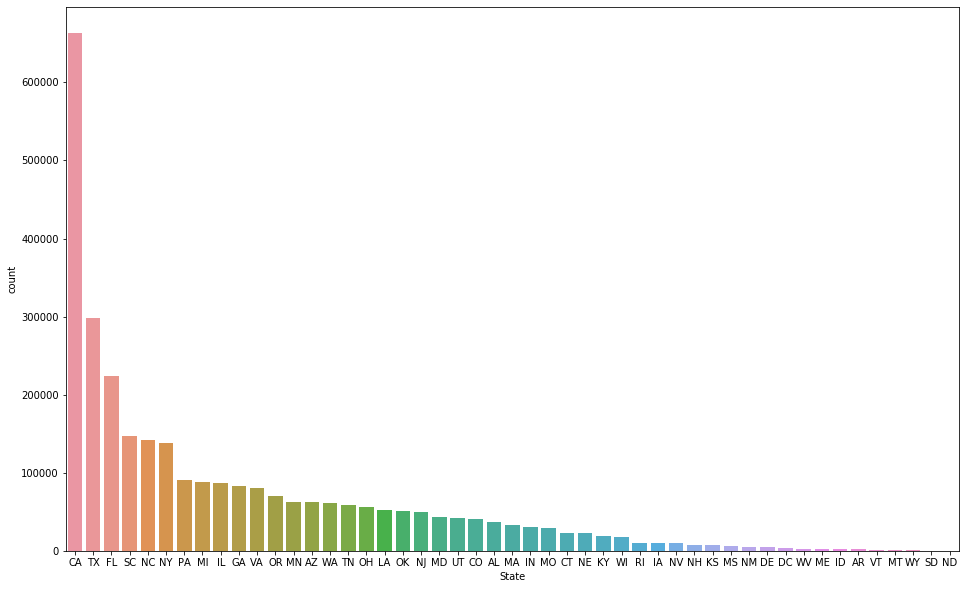

In [11]:
rdd = sc.parallelize(state_freq)
pd_states = rdd.toDF().toPandas()

# Plot data
fig,ax = plt.subplots(figsize=(16,10))
b = sns.barplot(pd_states['State'],pd_states['count'])
b.axes.set_title("Severity distribution for each state",fontsize=20)
b.set_xlabel("Number of Accidents",fontsize=15)
b.set_ylabel("State",fontsize=15)
b.tick_params(labelsize=10)

In [72]:
state_severity_freq = df.groupBy('State','Severity').count().orderBy('count',ascending=False).collect()

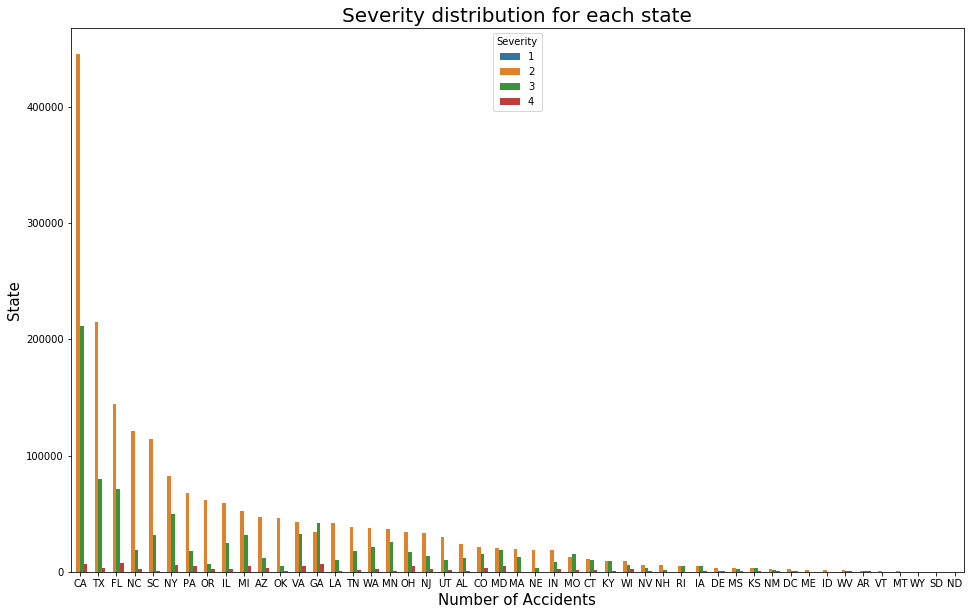

In [71]:
rdd = sc.parallelize(state_severity_freq)
pd_state_severity = rdd.toDF().toPandas()

# Plot data
fig,ax = plt.subplots(figsize=(16,10))
b = sns.barplot(x="State", y="count", hue="Severity", data=pd_state_severity)
#b = sns.barplot(pd_state_severity['State', 'Severity'],pd_state_severity['count'])
b.axes.set_title("Severity distribution for each state",fontsize=20)
b.set_xlabel("Number of Accidents",fontsize=15)
b.set_ylabel("State",fontsize=15)
b.tick_params(labelsize=10)

In [14]:
#rdd = sc.parallelize(state_severity_freq)
#hurr = rdd.filter(lambda c: rdd['Severity'] == '1')

#pd_states = rdd.toDF().toPandas()


# 
# Plot data
#fig,ax = plt.subplots(figsize=(16,10))
#sns.barplot(pd_states['Severity'],pd_states['count'])
#sns.barplot(pd_states['State']=='2',pd_states['count'])
#sns.barplot(pd_states['State']=='3',pd_states['count'])
#sns.barplot(pd_states['State']=='4',pd_states['count'])

### Weather conditions

In [15]:
weather_freq = df.groupBy('Weather_Condition').count().orderBy('count',ascending=False).collect()

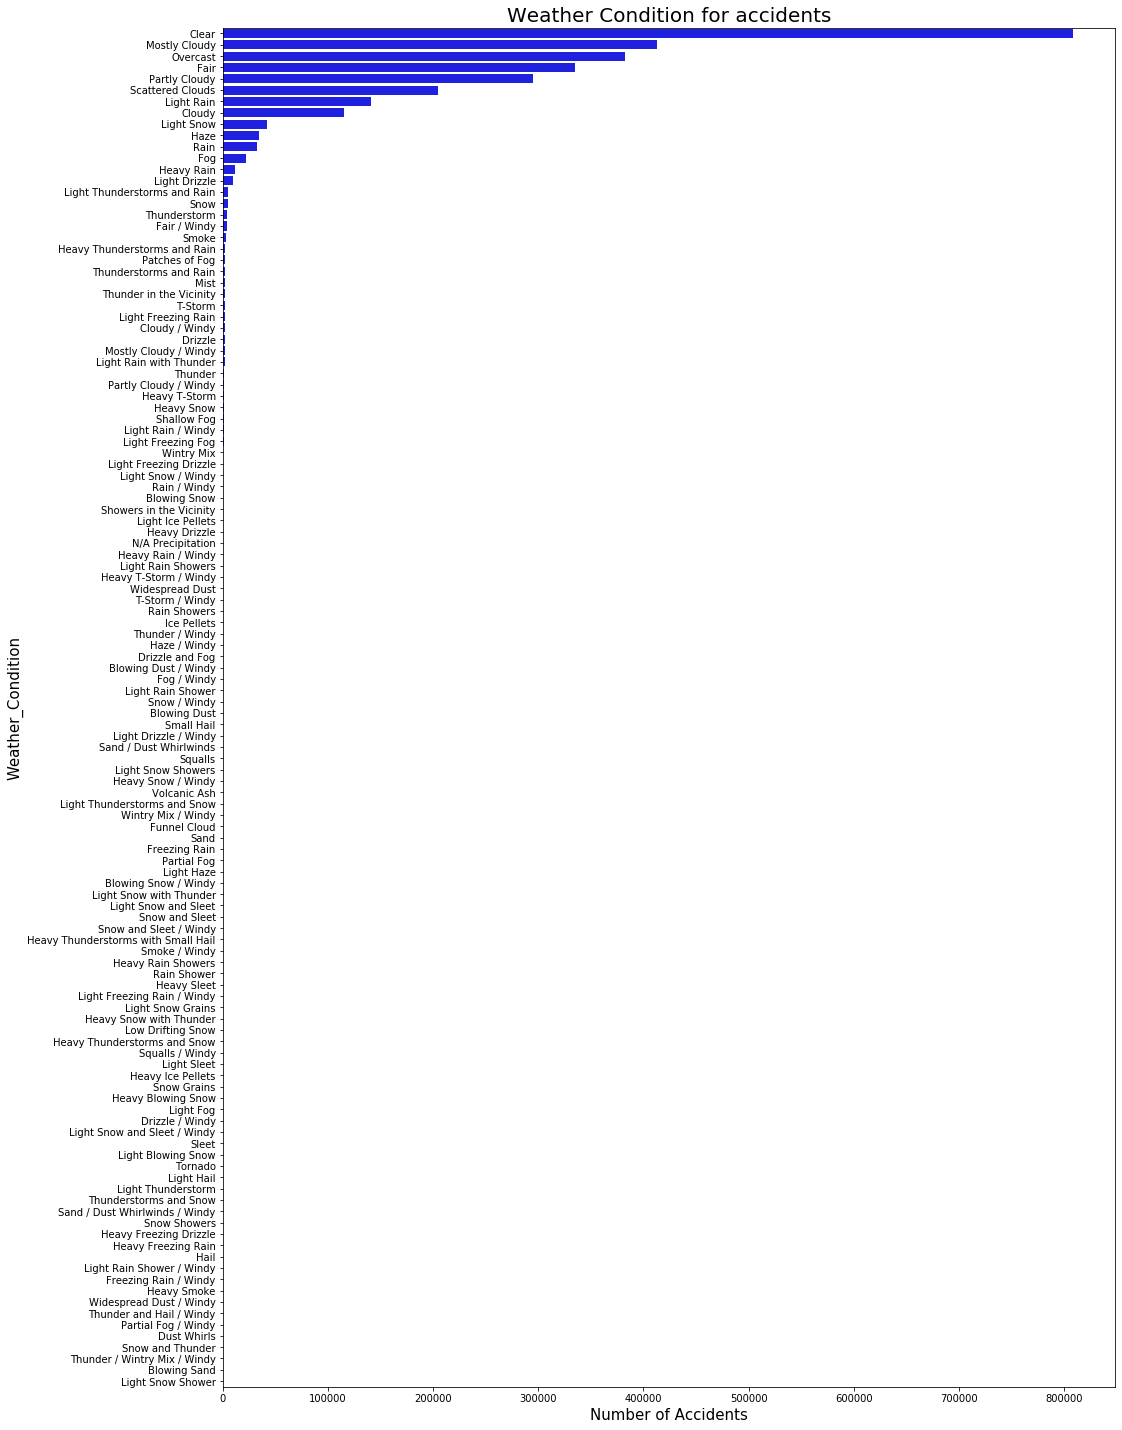

In [16]:
#display_limit = 12 # Limit on how many objects that should be displayed

fig, ax=plt.subplots(figsize=(16,25))

rdd = sc.parallelize(weather_freq)
pd_weather = rdd.toDF().toPandas()

b = sns.barplot(pd_weather['count'][:],pd_weather['Weather_Condition'][:], color="blue")

b.axes.set_title("Weather Condition for accidents",fontsize=20)
b.set_xlabel("Number of Accidents",fontsize=15)
b.set_ylabel("Weather_Condition",fontsize=15)
b.tick_params(labelsize=10)
plt.show()


In [17]:
# How severe was the condition for each type of weather?

### Time when accidents occured

In [29]:
df_time = df.selectExpr("hour(to_timestamp(from_utc_timestamp(Start_Time, Timezone), 'yyyy-MM-dd HH:mm:ss')) as Start_Time")
time_freq = df_time.groupBy('Start_Time').count().orderBy('count',ascending=False).collect()

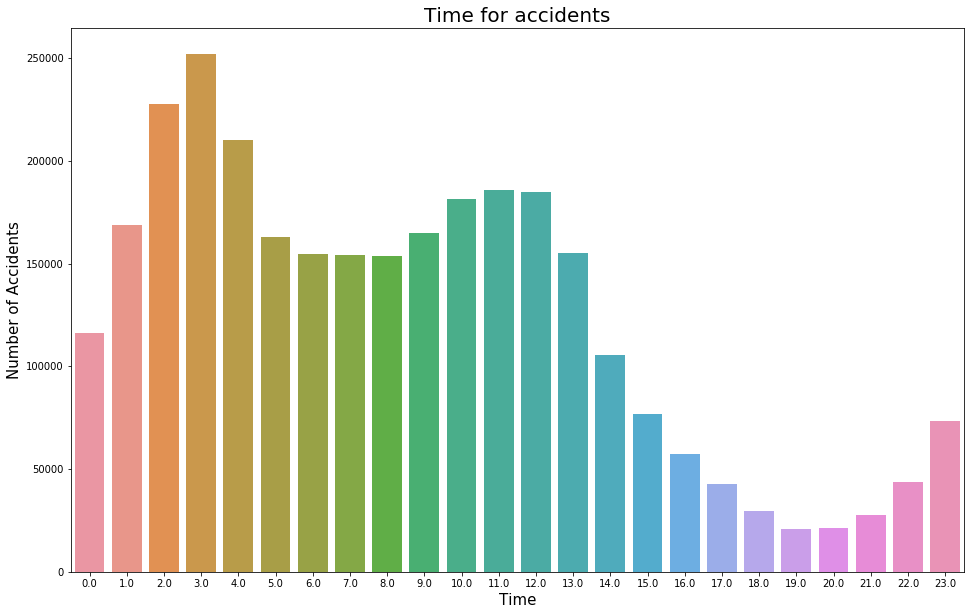

In [35]:
rdd = sc.parallelize(time_freq)
pd_time = rdd.toDF().toPandas()

# Plot data
fig,ax = plt.subplots(figsize=(16,10))

b = sns.barplot(pd_time['Start_Time'],pd_time['count'])
b.axes.set_title("Daytime for accidents",fontsize=20)
b.set_xlabel("Time (Hours)",fontsize=15)
b.set_ylabel("Number of Accidents",fontsize=15)
b.tick_params(labelsize=10)
plt.show()


### Development of accidents on Month basis

In [36]:
df_time = df.selectExpr("month(to_timestamp(from_utc_timestamp(Start_Time, Timezone), 'yyyy-MM-dd HH:mm:ss')) as Start_Time")
time_freq = df_time.groupBy('Start_Time').count().orderBy('count',ascending=False).collect()

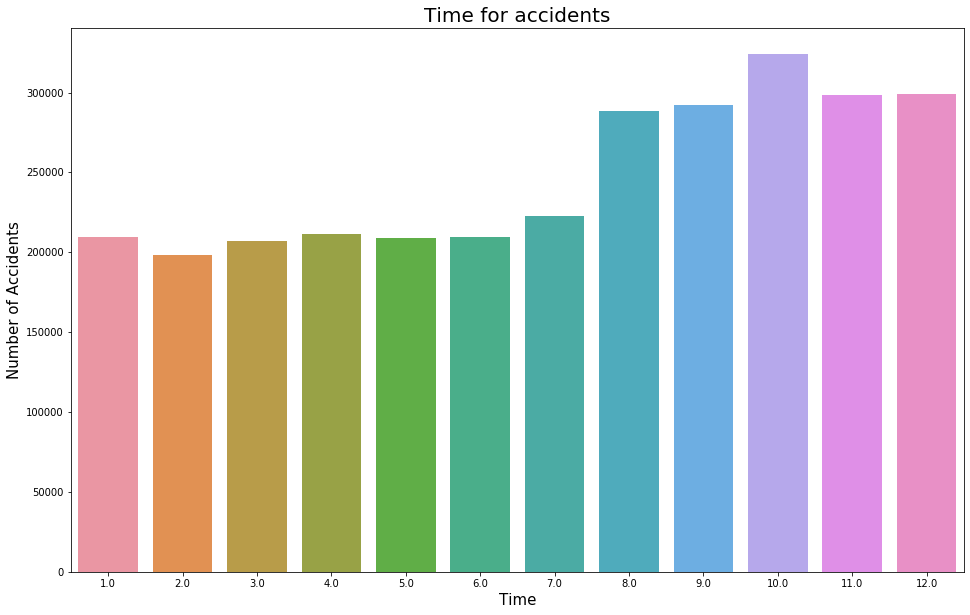

In [37]:
rdd = sc.parallelize(time_freq)
pd_time = rdd.toDF().toPandas()

# Plot data
fig,ax = plt.subplots(figsize=(16,10))

b = sns.barplot(pd_time['Start_Time'],pd_time['count'])
b.axes.set_title("Montly distribution for accidents",fontsize=20)
b.set_xlabel("Time (Month)",fontsize=15)
b.set_ylabel("Number of Accidents",fontsize=15)
b.tick_params(labelsize=10)
plt.show()


# 2. Preprocessing

In [ ]:
# Drop nan - Dont do this until cleaning above is fixed



# Drop features that is less than 0.01% chance
# Impute dataset
# Standarlize
# One-hot encoding

## Modify time

In [54]:
# Todo Replace with existing data in table
# Start_Time,End_Time, Weather_Timestamp, Timezone 
# 2016-02-08 05:46:00

df = df.withColumn('Start_Hour', hour(to_timestamp(from_utc_timestamp(df['Start_Time'], df['Timezone']), 'yyyy-MM-dd HH:mm:ss')))
df = df.withColumn('Start_Month', month(to_timestamp(from_utc_timestamp(df['Start_Time'], df['Timezone']), 'yyyy-MM-dd HH:mm:ss')))

df = df.withColumn('Weather_Hour', hour(to_timestamp(from_utc_timestamp(df['Weather_Timestamp'], df['Timezone']), 'yyyy-MM-dd HH:mm:ss')))
df = df.withColumn('Weather_Month', month(to_timestamp(from_utc_timestamp(df['Weather_Timestamp'], df['Timezone']), 'yyyy-MM-dd HH:mm:ss')))

# Drop weather since they are now converted
[colNum.remove(c) for c in ['Start_Time','Weather_Timestamp']] # Remove from numeric
colCat.extend(['Start_Hour','Start_Month','Weather_Hour','Weather_Month']) # Add to categorical values
colRem.extend(['Start_Time','Weather_Timestamp'])

## Drop data

In [56]:
# Drop missing values
# TODO check that it works
dfs= df
colRem.extend(['Number','Wind_Chill(F)','Precipitation(in)']) 

dfs = dfs.drop(*colRem)
dfs = dfs.drop()
print(colRem)

['ID', 'Source', 'End_Time', 'End_Lat', 'End_Lng', 'Description', 'Timezone', 'Start_Time', 'Weather_Timestamp', 'Number', 'Wind_Chill(F)', 'Precipitation(in)']


In [57]:
print(df.count())
print(dfs.count())

2974335
2974335


## Cast data

In [58]:
# Convert from string to integer values
# TODO: Does not work since data contains Nan/Null?
df = df.select(
        col('TMC').cast('string'),
        col('Severity').cast('string'),
        col('Start_Time').cast('int'),
        col('Start_Lat').cast('float'),
        col('Start_Lng').cast('float'),
        col('Distance(mi)').cast('float'),
        col('Street').cast('string'),
        col('Side').cast('string'),
        col('City').cast('string'),
        col('County').cast('string'),
        col('State').cast('string'),
        col('Zipcode').cast('string'),
        col('Country').cast('string'),
        col('Airport_Code').cast('string'),
        col('Weather_Timestamp').cast('int'),
        col('Temperature(F)').cast('float'),
        col('Wind_Chill(F)').cast('float'),
        col('Humidity(%)').cast('float'),
        col('Pressure(in)').cast('float'),
        col('Visibility(mi)').cast('float'),
        col('Wind_Direction').cast('float'),
        col('Wind_Speed(mph)').cast('float'),
        col('Weather_Condition').cast('string'),
        col('Amenity').cast('string'),
        col('Bump').cast('string'),
        col('Crossing').cast('string'),
        col('Give_Way').cast('string'),
        col('Junction').cast('string'),
        col('No_Exit').cast('string'),
        col('Railway').cast('string'),
        col('Roundabout').cast('string'),
        col('Station').cast('string'),
        col('Stop').cast('string'),
        col('Traffic_Calming').cast('string'),
        col('Traffic_Signal').cast('string'),
        col('Turning_Loop').cast('string'),
        col('Sunrise_Sunset').cast('string'),
        col('Civil_Twilight').cast('string'),
        col('Nautical_Twilight').cast('string'),
        col('Astronomical_Twilight').cast('string')
    ) 

### Kernel function

In [ ]:
# Remove City, Country, State, Zipcode, Airport_Code
# In order to reduce dimensionality a kernel function will be applied upon the Start_Lat and Start_Lng then fused in order to create a new set of data



### Impute 

In [ ]:
# Probobly a bad Idea but why not?
from pyspark.ml.feature import Imputer
# Wind_Chill,Wind_Speed
imputer = Imputer(inputCols=['Wind_Chill(F)', 'Wind_Speed(mph)'], outputCols=['Wind_Chill(F)', 'Wind_Speed(mph)'])
imputer.setStrategy("median")
model = imputer.fit(df)
imputedHousing = model.transform(df)
imputedHousing.select("Wind_Chill(F)", "Wind_Speed(mph)").show(5)

In [ ]:
# Scaling
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assembler = VectorAssembler(inputCols=colNum, outputCol="features")

featured_df = assembler.transform(df)

scaler = StandardScaler(inputCol="features", withMean=True, withStd=True, outputCol="scaledFeatures")

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(featured_df)

# Normalize each feature to have unit standard deviation.
scaled_df = scalerModel.transform(featured_df)
scaled_df.select(["features", "scaledFeatures"]).show(5)

In [ ]:
# Categorical values
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

indexers = [StringIndexer(inputCol=column, outputCol=column+"_num").fit(df) for column in list(set(colCat)-set(['date'])) ]

encoder = OneHotEncoder(inputCols=colCat, outputCols=[s + "_vec" for s in colCat])

print(indexers)

pipeline = Pipeline(stages=indexers)
df_r = pipeline.fit(df).transform(df)
df_r.show(5)

numPipeline = Pipeline(stages=[imputer, assembler, scaler])
catPipeline = Pipeline(stages=[indexers, encoder])

pipeline = Pipeline(stages=[numPipeline, catPipeline])
newHousing = pipeline.fit(df).transform(df)


## One-hot encoding

# 3. Feature importance

# 4. Pipeline